# Q-Learning Test Case Prioritization - Data Fetching and Preprocessing
This notebook connects to Azure Cosmos DB, fetches test execution logs, and prepares data for Q-learning-based prioritization.

In [1390]:

import pandas as pd
from azure.cosmos import CosmosClient
from datetime import datetime
import numpy as np
import random

# Cosmos DB Configuration
COSMOS_URI = "https://robotarm-cosmosdb.documents.azure.com:443/"
COSMOS_KEY = "XFTBU2Zs8inOM58z5ZDAlPyWxAoyqaZ8eYgEIocwOuQuLxsGzHukS6sdtDUE7RKyEOpaNsMIr7PVACDb0T8b5g=="
COSMOS_DB = "TestResultsDB"
COSMOS_CONTAINER = "Results"

# Initialize Cosmos DB client
client = CosmosClient(COSMOS_URI, credential=COSMOS_KEY)
database = client.get_database_client(COSMOS_DB)
container = database.get_container_client(COSMOS_CONTAINER)


In [1391]:

# Query all test results
query = "SELECT * FROM c"
items = list(container.query_items(query=query, enable_cross_partition_query=True))

# Parse and preprocess required fields
data = []
for item in items:
    data.append({
        "testCase_id": item.get("testCase", {}).get("id"),
        "testcase_name": item.get("testCase", {}).get("name") or item.get("testCaseTitle"),
        "duration_sec": round(item.get("durationInMs", 0) / 1000.0, 2),
        "status": item.get("outcome"),
        "agent": item.get("computerName"),
        "build_id": item.get("build", {}).get("id"),
        "release_id": item.get("releaseReference", {}).get("id"),
        "run_id": item.get("testRunId"),
        "failure_type": item.get("failureType"),
        "start_time": item.get("startedDate"),
        "end_time": item.get("completedDate"),
        "upload_time": item.get("uploadTimestamp")
    })


In [1392]:

# Load into DataFrame
df = pd.DataFrame(data)

# Preview data
print(" Execution Logs:")
df.head()


 Execution Logs:


,testCase_id,testcase_name,duration_sec,status,agent,build_id,release_id,run_id,failure_type,start_time,end_time,upload_time
0,17,RoboticPainter_FailsafeBlocksPainting {Autobot2},0.65,Passed,LAPTOP-ATOATJIH,34,77,144,None,2025-05-28T16:28:31.597Z,2025-05-28T16:28:32.243Z,2025-05-28T16:31:42.734460
1,18,HighPrecisionArm_BoundaryFailure {Autobot2},0.51,Passed,LAPTOP-ATOATJIH,34,77,144,None,2025-05-28T16:28:33.64Z,2025-05-28T16:28:34.147Z,2025-05-28T16:31:43.048369
2,19,ABBFlexiblePaintBot_LowEdgeCheck {Autobot2},1.79,Failed,LAPTOP-ATOATJIH,34,77,144,None,2025-05-28T16:28:34.147Z,2025-05-28T16:28:35.94Z,2025-05-28T16:31:43.080269
3,20,ABBPainterX_CycleStopWithError {Autobot2},60.00,Passed,LAPTOP-ATOATJIH,34,77,144,None,2025-05-28T16:28:35.943Z,2025-05-28T16:29:35.947Z,2025-05-28T16:31:43.095899
4,21,ABBIRB6000_MovementBoundaries {Autobot2},1.42,Passed,LAPTOP-ATOATJIH,34,77,144,None,2025-05-28T16:29:35.947Z,2025-05-28T16:29:37.37Z,2025-05-28T16:31:43.127066


In [1393]:
# List of columns to drop
columns_to_drop = ['agent', 'run_id', 'failure_type', 'build_id', 'release_id']

# Drop the columns
df.drop(columns=columns_to_drop, inplace=True)

# Optional: verify result
print("✅ Remaining columns:")
print(df.columns.tolist())


✅ Remaining columns:
['testCase_id', 'testcase_name', 'duration_sec', 'status', 'start_time', 'end_time', 'upload_time']


In [1394]:
columns_to_check = ['testCase_id', 'testcase_name', 'duration_sec', 'status', 'start_time', 'end_time', 'upload_time']

# Show count of missing values in each column
missing_counts = df[columns_to_check].isnull().sum()
print("Missing values per column:")
print(missing_counts)


Missing values per column:
testCase_id       0
testcase_name     0
duration_sec      0
status           18
start_time        0
end_time          0
upload_time       0
dtype: int64


In [1395]:
# ✅ Step 1: Convert time columns to datetime and remove timezone
df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce').dt.tz_localize(None)
df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce').dt.tz_localize(None)
df['upload_time'] = pd.to_datetime(df['upload_time'], errors='coerce').dt.tz_localize(None)

# ✅ Step 2: Sort and compute time since last run
df = df.sort_values(by=['testCase_id', 'upload_time'])
df['time_since_last_run'] = (
    df.groupby('testCase_id')['upload_time']
    .diff()
    .dt.total_seconds()
    .div(3600)
    .round(4)
)


In [1396]:
df['time_since_last_run'] = df['time_since_last_run'].fillna(0)



In [1397]:


# Sort by testCaseId and upload_time
df = df.sort_values(by=['testCase_id', 'upload_time'])

# Compute time since last run in hours
df['time_since_last_run'] = df.groupby('testCase_id')['upload_time'].diff()


In [1398]:
df = df[df["time_since_last_run"].notna()]


In [1399]:
df.head()

,testCase_id,testcase_name,duration_sec,status,start_time,end_time,upload_time,time_since_last_run
47,10,PaintProSystem_ResetPosition {Autobot1},0.69,Passed,2025-05-28 18:09:13.800,2025-05-28 18:09:14.490,2025-05-28 18:09:58.977880,0 days 00:27:50.214068
69,10,PaintProSystem_ResetPosition {Autobot1},1.20,Passed,2025-05-28 19:50:33.727,2025-05-28 19:50:34.927,2025-05-28 19:51:28.559985,0 days 01:41:29.582105
91,10,PaintProSystem_ResetPosition {Autobot1},1.46,Passed,2025-05-28 20:28:27.063,2025-05-28 20:28:28.520,2025-05-28 20:29:13.760958,0 days 00:37:45.200973
123,10,PaintProSystem_ResetPosition {Autobot1},0.34,Passed,2025-05-29 11:22:51.033,2025-05-29 11:22:51.373,2025-05-29 11:23:31.495226,0 days 14:54:17.734268
155,10,PaintProSystem_ResetPosition {Autobot1},1.50,Passed,2025-05-31 19:58:25.657,2025-05-31 19:58:27.160,2025-05-31 19:59:14.994027,2 days 08:35:43.498801


In [1400]:
# Step 1: Failure flag and rate
df['failure'] = df['status'] == 'Failed'
df['failure_rate'] = df.groupby('testcase_name')['failure'].transform('mean')

# Step 2: Encode test case names and status
df['testcase_encoded'] = df['testcase_name'].astype('category').cat.codes
df['status_encoded'] = df['status'].map({'Passed': 0, 'Failed': 1, 'Warning': 0.5}).fillna(0)

# Step 3: Time since last run in minutes
df['time_since_last_run_minutes'] = df['time_since_last_run'].dt.total_seconds() / 60

# Step 4: Normalize relevant features
df['normalized_time'] = (
    df['time_since_last_run_minutes'] - df['time_since_last_run_minutes'].min()
) / (df['time_since_last_run_minutes'].max() - df['time_since_last_run_minutes'].min())

df['normalized_duration'] = (
    df['duration_sec'] - df['duration_sec'].min()
) / (df['duration_sec'].max() - df['duration_sec'].min())

df['normalized_failure_rate'] = (
    df['failure_rate'] - df['failure_rate'].min()
) / (df['failure_rate'].max() - df['failure_rate'].min())

In [1401]:
# Step 6: Define state
df['state'] = list(zip(
    df['normalized_failure_rate'],
    df['normalized_time'],
    df['normalized_duration']
))

# Step 7: Map state to index using unique states
unique_states = list(set(df['state']))
state_to_index = {state: i for i, state in enumerate(unique_states)}
df['state_index'] = df['state'].map(state_to_index)

#

In [1402]:

# Step 7: Define cost-sensitive reward
df['reward'] = (
    0.5 * df['normalized_failure_rate'] +
    0.3 * df['normalized_time'] -
    0.2 * df['normalized_duration']
)

In [ ]:
# Step 8: Initialize Q-table (state x action [0=skip, 1=run])
Q_table = np.zeros((len(unique_states), 2))

# Q-learning parameters
alpha = 0.1
gamma = 0.9
epsilon = 1.0
episodes = 20000

# Optional: reward tracking
episode_rewards = []


In [1404]:
episode_rewards = []


In [1405]:
# Step 9: Training loop
for episode in range(episodes):
    row = df.sample(1).iloc[0]
    s_idx = row['state_index']

    # Epsilon-greedy policy
    if random.uniform(0, 1) < epsilon:
        a_idx = random.choice([0, 1])  # Explore
    else:
        a_idx = np.argmax(Q_table[s_idx])  # Exploit

    # Reward for this action in current state
    reward = row['reward']
    old_value = Q_table[s_idx, a_idx]
    next_max = np.max(Q_table[s_idx])  # No next state yet

    # Q-learning update
    Q_table[s_idx, a_idx] = old_value + alpha * (reward + gamma * next_max - old_value)

    episode_rewards.append(reward)
    epsilon = max(0.01, epsilon * 0.995)  # Decay exploration


In [1406]:
total_reward = 0

for episode in range(episodes):
    row = df.sample(1).iloc[0]
    s_idx = row['state_index']
    
    if random.uniform(0, 1) < epsilon:
        a_idx = random.choice([0, 1])  # Explore
    else:
        a_idx = np.argmax(Q_table[s_idx])  # Exploit

    reward = row['reward']
    total_reward += reward

    old_value = Q_table[s_idx, a_idx]
    next_max = np.max(Q_table[s_idx])
    Q_table[s_idx, a_idx] = old_value + alpha * (reward + gamma * next_max - old_value)

    epsilon = max(0.01, epsilon * 0.995)  # Decay exploration

    # After each episode
    episode_rewards.append(total_reward)


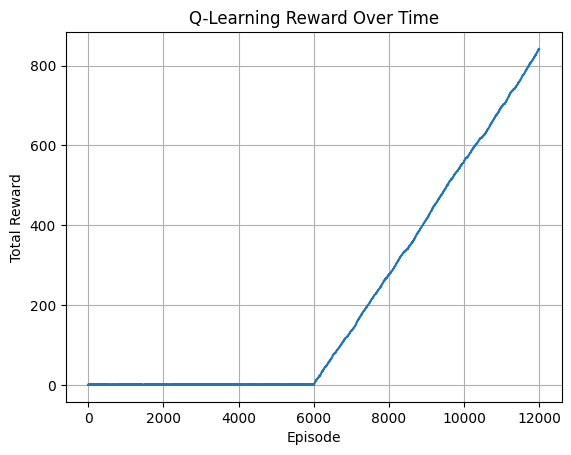

In [1407]:
import matplotlib.pyplot as plt

plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Q-Learning Reward Over Time")
plt.grid(True)
plt.show()


In [1408]:
# ✅ Step 1: Add Q-value for 'run' action (action = 1)
df["Q_value"] = df["state_index"].apply(lambda idx: Q_table[idx, 1])

# ✅ Step 2: Predict best action (0 = skip, 1 = run)
df["runDecision"] = df["state_index"].apply(lambda idx: np.argmax(Q_table[idx]))

# ✅ Step 3: Filter test cases where best action is 'run'
selected_tests = df[df["runDecision"] == 1].copy()

# ✅ Step 4: Sort selected test cases by Q-value (descending)
selected_tests = selected_tests.sort_values(by="Q_value", ascending=False)

# ✅ Step 5: Drop duplicates by testcase_name
selected_tests = selected_tests.drop_duplicates(subset="testcase_name", keep="first")

# ✅ Step 6: Optional – set testcase_id as index (if available)
if "testCase_id" in selected_tests.columns:
    selected_tests.set_index("testCase_id", inplace=True)

# ✅ Step 7: Save selected test cases to CSV
selected_tests.to_csv("CosmosDB/scheduled_tests_qlearning.csv")

# ✅ Step 8: Display top results in terminal
print("\n📊 Q-Learning Selected Test Cases:")
print(selected_tests[[
    "testcase_name",
    "Q_value",
    "reward",
    "duration_sec",
    "time_since_last_run_minutes"
]].head(50))

print("\n✅ Saved to: CosmosDB/scheduled_tests_qlearning.csv")



📊 Q-Learning Selected Test Cases:
                                                testcase_name   Q_value  \
testCase_id                                                               
22                    IndustrialPaintBot_ValidStop {Autobot2}  1.006850   
13                  ABBXPaintControl_ResetAndRetry {Autobot1}  0.868761   
26                ABBPaintingBot_RecoveryFromCrash {Autobot2}  0.804415   
36                     SimPaintRobot_ResetSequence {Autobot3}  0.770903   
6                    PaintIRB5500_ResetAfterFailure{Autobot1}  0.730896   
32                         ABB5500_ResetAndOperate {Autobot3}  0.636009   
19                ABBFlexiblePaintBot_LowEdgeCheck {Autobot2}  0.562835   
23                   PaintLineIRB_ValidPositioning {Autobot2}  0.498245   
5                     PaintABB5400_MotionRangeCheck{Autobot1}  0.440642   
25                       CompactPaintBot_QuickTest {Autobot2}  0.433487   
33                  SmartPainter_PositionPrecision {Autobot3}  0.